In [1]:
from gumbel_softmax import GumbelSoftmax, GumbelSoftmaxLayer
import theano.tensor as T
import numpy as np

### Simple demo
* Sample from gumbel-softmax
* Average over samples

In [2]:
temperature = 0.01
logits = np.linspace(-2,2,10).reshape([1,-1])
gumbel_softmax = GumbelSoftmax(t=temperature)(logits)
softmax = T.nnet.softmax(logits)

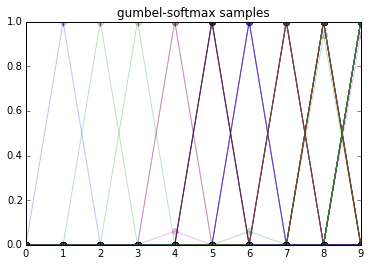

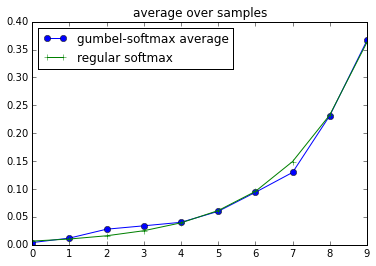

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('gumbel-softmax samples')
for i in range(100):
    plt.plot(range(10),gumbel_softmax.eval()[0],marker='o',alpha=0.25)
plt.ylim(0,1)
plt.show()

plt.title('average over samples')
plt.plot(range(10),np.mean([gumbel_softmax.eval()[0] for _ in range(500)],axis=0),
         marker='o',label='gumbel-softmax average')

plt.plot(softmax.eval()[0],marker='+',label='regular softmax')
plt.legend(loc='best')

# Autoencoder with gumbel-softmax

* We do not use any bayesian regularization, simply optimizer by backprop
* Hidden layer contains 32 units, split into 8 blocks of 4 variables
* Gumbel-softmax is computed over each block

In [4]:
from sklearn.datasets import load_digits
X = load_digits().data

In [5]:
import lasagne
from lasagne.layers import *
import theano

#graph inputs and shareds
input_var = T.matrix()
temp = theano.shared(np.float32(1),'temperature',allow_downcast=True)

#architecture: encoder
nn = l_in = InputLayer((None,64),input_var)
nn = DenseLayer(nn,64,nonlinearity=T.tanh)
nn = DenseLayer(nn,32,nonlinearity=T.tanh)

#bottleneck
nn = DenseLayer(nn,32,nonlinearity=None)
nn = reshape(nn,(-1,4)) #reshape so that softmax would be applied over blocks of 4
nn = GumbelSoftmaxLayer(nn,t=temp)
nn = bottleneck = reshape(nn,(-1,32))

#decoder
nn = DenseLayer(nn,32,nonlinearity=T.tanh)
nn = DenseLayer(nn,64,nonlinearity=T.tanh)
nn = DenseLayer(nn,64,nonlinearity=None)

#loss and updates
loss = T.mean((get_output(nn)-input_var)**2)
updates = lasagne.updates.adam(loss,get_all_params(nn))

#compile
train_step = theano.function([input_var],loss,updates=updates)
evaluate = theano.function([input_var],loss)

## Training loop
* We gradually reduce temperature from 1 to 0.01 over time

In [6]:
for i,t in enumerate(np.logspace(0,-2,10000)):
    sample = X[np.random.choice(len(X),32)]
    temp.set_value(t)
    mse = train_step(sample)
    if i %100 ==0:
        print '%.3f'%evaluate(X),

59.870 21.652 18.887 18.784 18.785 18.799 18.780 18.789 18.788 18.789 18.782 18.796 18.790 18.786 18.784 18.714 18.539 18.119 17.026 15.599 14.553 13.908 13.185 12.472 11.917 11.400 11.082 10.831 10.530 10.369 10.112 9.983 9.763 9.597 9.440 9.286 9.185 9.011 8.928 8.815 8.697 8.669 8.597 8.492 8.469 8.340 8.276 8.208 8.145 8.117 8.174 8.055 8.074 7.981 7.915 8.097 7.982 8.036 8.047 7.959 7.868 7.952 7.878 7.750 7.713 7.793 7.755 7.779 7.816 7.873 7.800 7.838 7.745 7.673 7.697 7.912 7.670 7.627 7.717 7.663 7.557 8.003 7.773 7.720 7.674 7.746 7.803 7.774 7.783 7.867 7.849 7.883 7.688 7.737 7.655 7.644 7.632 7.808 7.996 7.837


In [7]:
#functions for visualization
get_sample = theano.function([input_var],get_output(nn))
get_sample_hard = theano.function([input_var],get_output(nn,hard_max=True))
get_code = theano.function([input_var],get_output(bottleneck,hard_max=False))


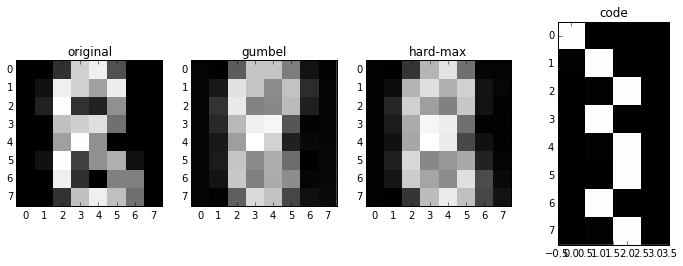

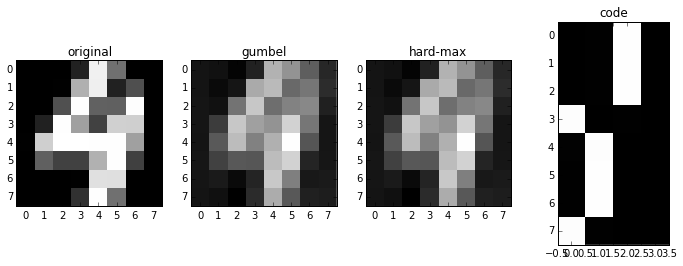

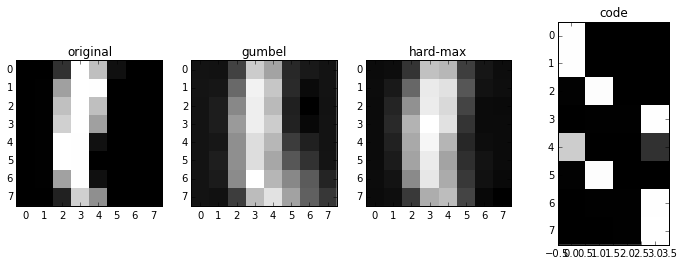

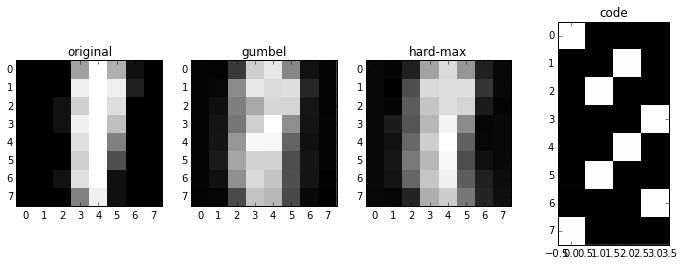

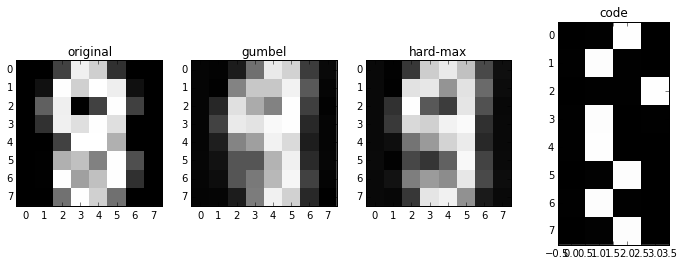

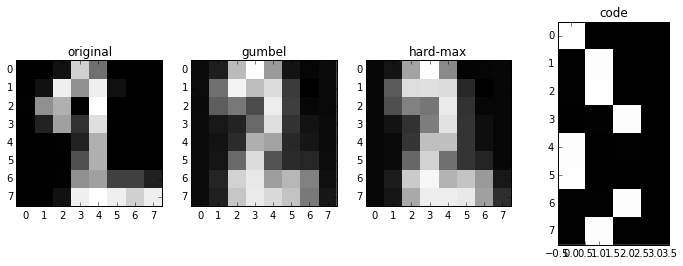

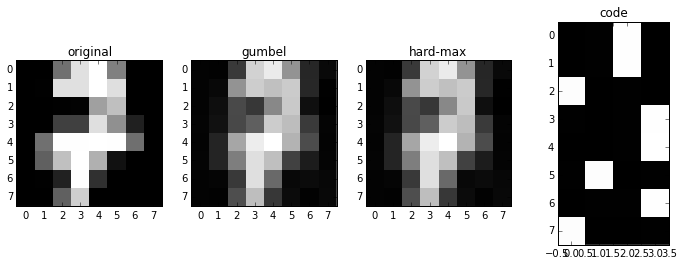

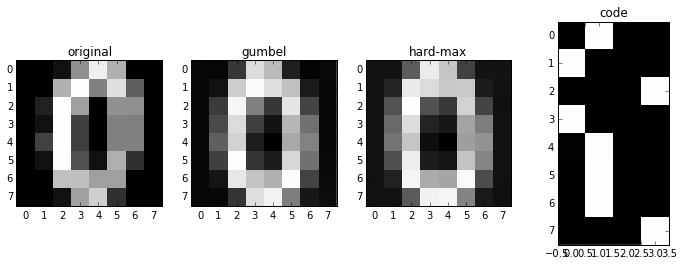

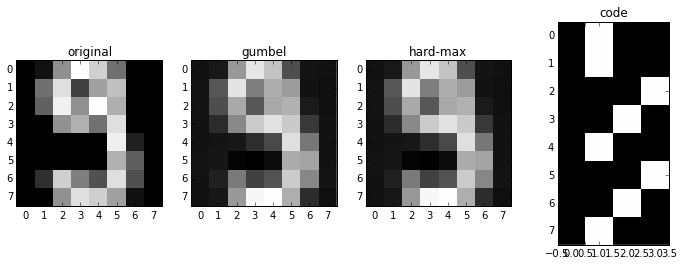

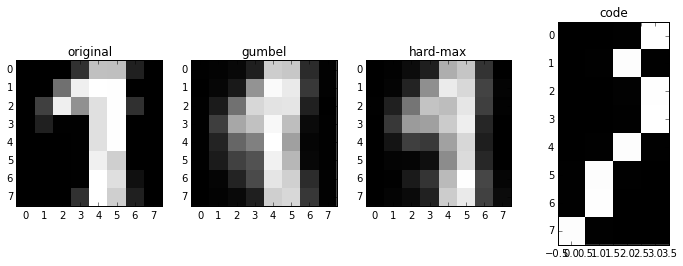

In [8]:
for i in range(10):
    X_sample = X[np.random.randint(len(X)),None,:]
    plt.figure(figsize=[12,4])
    plt.subplot(1,4,1)
    plt.title("original")
    plt.imshow(X_sample.reshape([8,8]),interpolation='none',cmap='gray')
    plt.subplot(1,4,2)
    plt.title("gumbel")
    plt.imshow(get_sample(X_sample).reshape([8,8]),interpolation='none',cmap='gray')
    plt.subplot(1,4,3)
    plt.title("hard-max")
    plt.imshow(get_sample_hard(X_sample).reshape([8,8]),interpolation='none',cmap='gray')
    plt.subplot(1,4,4)
    plt.title("code")
    plt.imshow(get_code(X_sample).reshape(8,4),interpolation='none',cmap='gray')
    plt.show()